In [248]:
import numpy as np
import pandas as pd
import os

from pathlib import Path
from tqdm import tqdm

import torchaudio
from sklearn.model_selection import train_test_split

In [249]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
from torch.utils.data import DataLoader,Dataset,random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [250]:
# from transformers import AutoProcessor, Wav2Vec2Model
import torch as t
import numpy as np
t.cuda.set_device(8)

import warnings
warnings.filterwarnings("ignore")
device = t.device('cuda' if t.cuda.is_available() else 'cpu')

In [251]:
audio_dir = "/raid/amana/lavish_multi_model/emotion_detection/data/raw_audio/"
base_path = "/raid/amana/lavish_multi_model/emotion_detection/"

In [252]:
df = pd.read_csv("/raid/amana/lavish_multi_model/emotion_detection/data/text_data.csv")
df['filename'] = [f'{audio_dir}dia{a}_utt{b}.wav' for a,b in zip(df['Dialogue_ID'],df['Utterance_ID'])]
df.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,filename
0,1,"Oh my God, hes lost it. Hes totally lost it.",Phoebe,sadness,negative,0,0,4,7,"00:20:57,256","00:21:00,049",/raid/amana/lavish_multi_model/emotion_detecti...
1,2,What?,Monica,surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261",/raid/amana/lavish_multi_model/emotion_detecti...
2,3,"Or! Or, we could go to the bank, close our acc...",Ross,neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915",/raid/amana/lavish_multi_model/emotion_detecti...
3,4,Youre a genius!,Chandler,joy,positive,1,1,4,4,"00:12:32,334","00:12:33,960",/raid/amana/lavish_multi_model/emotion_detecti...
4,5,"Aww, man, now we wont be bank buddies!",Joey,sadness,negative,1,2,4,4,"00:12:34,211","00:12:37,505",/raid/amana/lavish_multi_model/emotion_detecti...


In [253]:
print(f"Step 0: {len(df)}")
df["status"] = df["filename"].apply(lambda path: True if os.path.exists(path) else None)
df = df.dropna(subset=["filename"])
df = df.drop("status", 1)
print(f"Step 1: {len(df)}")
df = df.sample(frac=1)
df = df.reset_index(drop=True)
df.head()

Step 0: 1109
Step 1: 1109


,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,filename
0,6,"Now, theres two reasons.",Chandler,neutral,neutral,1,3,4,4,"00:12:38,466","00:12:39,841",/raid/amana/lavish_multi_model/emotion_detecti...
1,1119,"Ugh, how can you even ask that question?!",Rachel,surprise,positive,107,3,6,20,"0:02:45,501","0:02:48,182",/raid/amana/lavish_multi_model/emotion_detecti...
2,758,Yeah! You can hook it up to your TV,Rachel,joy,positive,71,4,7,13,"00:13:26,514","00:13:29,015",/raid/amana/lavish_multi_model/emotion_detecti...
3,104,"Come on man! Listen so uh, are you gonna sque...",Joey,joy,positive,10,3,5,20,"00:07:01,254","00:07:07,342",/raid/amana/lavish_multi_model/emotion_detecti...
4,1107,Yknow what Greg?,Monica,anger,negative,105,10,8,4,"00:22:03,488","00:22:04,947",/raid/amana/lavish_multi_model/emotion_detecti...


In [254]:
print("Labels: ", df["Emotion"].unique())
print()
df.groupby("Emotion").count()[["filename"]]

Labels:  ['neutral' 'surprise' 'joy' 'anger' 'fear' 'sadness' 'disgust']



,filename
Emotion,
anger,153
disgust,22
fear,40
joy,163
neutral,470
sadness,111
surprise,150


In [299]:
save_path = "/raid/amana/lavish_multi_model/emotion_detection/data/"

train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["Emotion"])

train_df = train_df.reset_index(drop=True)
random_float_array = np.random.uniform(7, 10.0, len(train_df.Emotion))
train_df["emotion"] = train_df['Emotion']
train_df['Emotion'] = random_float_array.round(2)
train_df = train_df.rename(columns={"Emotion":"values"})

test_df = test_df.reset_index(drop=True)
random_float_array = np.random.uniform(7, 10.0, len(test_df.Emotion))
test_df["emotion"] = test_df['Emotion']
test_df['Emotion'] = random_float_array.round(2)
test_df = test_df.rename(columns={"Emotion":"values"})

train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)


print(train_df.shape)
print(test_df.shape)

(887, 13)
(222, 13)


In [300]:
from transformers import AutoProcessor, Wav2Vec2Model

processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [301]:
import numpy as np 
import soundfile as sf
import librosa


def getVggoud_proc(filename):
    audio_length = 1.5
    idx=0
    samples, samplerate = librosa.load(filename)

    if samples.shape[0] > 16000*(audio_length+0.1):
        sample_indx = np.linspace(0, samples.shape[0]-16000*(audio_length+0.1), num=1, dtype=int)
        samples = samples[sample_indx[idx]:sample_indx[idx]+int(16000*audio_length)]
    else:
        samples = np.tile(samples,int(audio_length))[:int(16000*audio_length)]

    samples[samples > 1.] = 1
    samples[samples < -1.] = -1
    
    return samples

def resample_audio(arr,sr):
    return librosa.util.fix_length(arr, size=sr)

In [302]:
def get_dataset_classification(df):
    emotion_label = {'anger' : 1, 'disgust' : 2, 'fear' : 3,
                 'joy' : 4, 'neutral' : 5, 'sadness' : 6, 'surprise' : 0}
    labels = list(df['emotion'])
    onlyfiles = list(df['filename'])
    res = []
    shapes = []
    for a,label in zip(onlyfiles,labels):
        try:
            res1 = getVggoud_proc(a)
            shapes.append(res1.shape)
            res.append([res1,label])
        except:
            continue
    shapes = np.array(shapes)
    true_shapes = shapes>5000
    res = [a for a,b in zip(res,true_shapes) if b[0] == True]
    final_len = 16000
    final_dataset = [[resample_audio(a[0],final_len),emotion_label[a[1]]] for a in res]
    return final_dataset

def get_dataset_regression(df):
    labels = list(df['values'])
    onlyfiles = list(df['filename'])
    res = []
    shapes = []
    for a,label in zip(onlyfiles,labels):
        try:
            res1 = getVggoud_proc(a)
            shapes.append(res1.shape)
            res.append([res1,label])
        except:
            continue
    shapes = np.array(shapes)
    true_shapes = shapes>5000
    res = [a for a,b in zip(res,true_shapes) if b[0] == True]
    final_len = 16000
    final_dataset = [[resample_audio(a[0],final_len),a[1]] for a in res]
    return final_dataset


In [303]:
test_df['values']

0      7.91
1      7.45
2      8.39
3      8.06
4      8.37
       ... 
217    7.96
218    9.39
219    7.67
220    8.39
221    7.81
Name: values, Length: 222, dtype: float64

In [304]:
train_dataset = get_dataset_regression(train_df)
test_dataset = get_dataset_regression(test_df)

In [305]:
from transformers import AutoProcessor, Wav2Vec2Model

processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [306]:
def get_final_dataset(dataset):
    final_dataset = []
    for a in dataset:
        inputs = processor(a[0], sampling_rate=16000, return_tensors="pt").to(device)
        with t.no_grad():
            outputs = model(**inputs).extract_features
            final_dataset.append([outputs.squeeze(0),a[1]])
    return final_dataset

In [307]:
train_dataset1 = get_final_dataset(train_dataset)

In [308]:
test_dataset1 = get_final_dataset(test_dataset)

In [309]:
train_dataloader = DataLoader(train_dataset1, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset1, batch_size=1,shuffle=False)

In [310]:
t.save(train_dataloader.dataset, 'wave2_vec_diff_reg_data_train_dataset.pth')

# Save the testing DataLoader
t.save(test_dataloader.dataset, 'wave2_vec_diff_reg_data_test_dataset.pth')

In [311]:
t.cuda.set_device(8)
device = t.device('cuda' if t.cuda.is_available() else 'cpu')

In [312]:
class EmotionMLP_cls(nn.Module):
    def softmax(self,x):
        e_x = t.exp(x - t.max(x))
        return e_x / e_x.sum()
    
    def __init__(self, num_classes):
        super(EmotionMLP_cls, self).__init__()
        self.input_matrix = nn.Parameter(t.rand(49,1))
        self.fc1 = nn.Linear(512,64)
        self.fc2 = nn.Linear(64, 1)

    
    def forward(self, x):
        x = t.matmul(x.t(),self.input_matrix)
        x = x.view(-1, 512)
        x = t.relu(self.fc1(x))
        x = t.relu(self.fc2(x))
        x = t.sigmoid(x)
        return x
    
class EmotionMLP_reg(nn.Module):
    def softmax(self,x):
        e_x = t.exp(x - t.max(x))
        return e_x / e_x.sum()
    
    def __init__(self):
        super(EmotionMLP_reg, self).__init__()
        self.input_matrix = nn.Parameter(t.rand(49,1))
        self.fc1 = nn.Linear(512,32)
        self.fc2 = nn.Linear(32, 1)

    
    def forward(self, x):
        x = t.matmul(x.t(),self.input_matrix)
        x = x.view(-1, 512)
        x = t.relu(self.fc1(x))
        x = t.relu(self.fc2(x)).double()
        return x

In [313]:
model = EmotionMLP_reg().to(device)

x = t.rand(49,512)
model(x.to(device))

tensor([[0.]], device='cuda:8', dtype=torch.float64, grad_fn=<CopyBackwards>)

In [314]:
model = EmotionMLP_reg().to(device)

criterion = nn.MSELoss()
optimizer = t.optim.Adam(model.parameters(), lr=0.0001)

In [315]:
def plot_loss(lossarr,epochs):
    plt.plot(range(1,epochs+1),lossarr)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

In [316]:
def test(model,test_loader,device):
    
    def accuracy1(y_true, y_pred):
        eq = t.eq(y_true, y_pred).int()
        return sum(eq)/len(eq)
    def mean_absolute_percentage_error(y_true, y_pred):
        # print(y_true,y_pred)
        return t.mean(t.abs((y_true - y_pred) / y_true))*100
    
    acc = 0
    mape = 0
    with t.no_grad():
        model.eval()
        for x,y in test_loader:
            x = x.squeeze(0)
            outputs = model(x.to(device))
            outputs1 = outputs.detach().cpu()
            mape += mean_absolute_percentage_error(t.tensor([y]),outputs1)
        print(f"mape: {((mape/len(test_loader)))}")

In [317]:
def train(model,train_loader,optimizer,criterion,num_epochs,device):
    loss_arr = []
    for epoch in tqdm(range(num_epochs)):
        # model.train()
        total_loss = 0
        for x,y in train_loader:
            x = x.squeeze(0)
            # Forward pass
            outputs = model(x.to(device))
            loss = criterion(outputs,t.tensor([y],dtype=float).to(device)).to(device)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        loss_arr.append(total_loss/len(train_loader))
        
        if epoch%5 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss/len(train_loader)}')
            test(model,test_dataloader,device)
    return loss_arr

num_epochs = 50
lossarr = train(model,train_dataloader,optimizer,criterion,num_epochs,device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Training Loss: 4.437607669340425


  2%|▏         | 1/50 [00:05<04:19,  5.30s/it]

mape: 10.24863724485304


  6%|▌         | 3/50 [00:14<03:46,  4.82s/it]

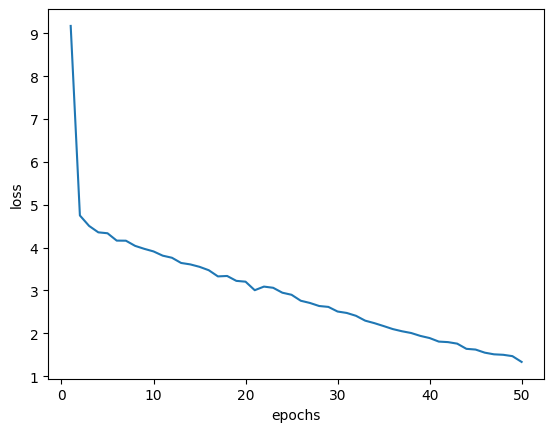

In [ ]:
plot_loss(lossarr,num_epochs)

In [ ]:
from sklearn.metrics import mean_absolute_error

def test(model,test_loader,device):
    
    def accuracy1(y_true, y_pred):
        eq = t.eq(y_true, y_pred).int()
        return sum(eq)/len(eq)
    def mean_absolute_percentage_error(y_true, y_pred):
        # print(y_true,y_pred)
        return t.mean(t.abs((y_true - y_pred) / y_true))*100
    
    def MAE(y_true,y_pred):
        y_true = y_true.detach().numpy()
        y_pred = y_pred.detach().numpy()
        return mean_absolute_error(y_true, y_pred)
        
    
    acc = 0
    mape = 0
    mae = 0
    with t.no_grad():
        model.eval()
        for x,y in test_loader:
            x = x.squeeze(0)
            outputs = model(x.to(device))
            outputs1 = outputs.detach().cpu()
            mape += mean_absolute_percentage_error(t.tensor([y]),outputs1)
            mae += MAE(t.tensor([y]),outputs1)
        print(f"mape: {((mape/len(test_loader))) :0.2f}")
        print(f"mae: {((mae/len(test_loader))) :0.2f}")

In [ ]:
test(model,test_dataloader,device)

mape: 22.95
mae: 1.98
